## 0 Load packages

In [ ]:
# Data related
import numpy as np 
import pandas as pd
from sklearn.metrics import accuracy_score, log_loss
import scikitplot as skplt

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
# Import custom functions
from utils_functions import *

## 1. Load data 

In [ ]:
df = pd.read_csv('../data/processed/train_variants_text.csv')
df=df.dropna(subset=['Text'])

## 2. LSTM 

In [144]:
tokenizer=Tokenizer()
X = tokenizer.texts_to_sequences(df['Text'].values)
X = pad_sequences(X, maxlen=2000)

In [150]:
Y = pd.get_dummies(df['Class']).values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42, stratify=Y)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(2652, 2000) (2652, 9)
(664, 2000) (664, 9)


In [151]:
# Create a LSTM model
model = baseline_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 2000, 64)          11599552  
_________________________________________________________________
lstm_17 (LSTM)               (None, 196)               204624    
_________________________________________________________________
dense_17 (Dense)             (None, 9)                 1773      
Total params: 11,805,949
Trainable params: 11,805,949
Non-trainable params: 0
_________________________________________________________________
None


In [154]:
## Fit train data
model.fit(X_train, Y_train, validation_split=0.2, epochs = 3)


Train on 2121 samples, validate on 531 samples
Epoch 1/3
2121/2121 [==============================] - 347s 164ms/step - loss: 1.8929 - categorical_crossentropy: 1.8929 - val_loss: 1.8667 - val_categorical_crossentropy: 1.8667
Epoch 2/3
2121/2121 [==============================] - 341s 161ms/step - loss: 1.8422 - categorical_crossentropy: 1.8422 - val_loss: 1.8824 - val_categorical_crossentropy: 1.8824
Epoch 3/3
2121/2121 [==============================] - 342s 161ms/step - loss: 1.8354 - categorical_crossentropy: 1.8354 - val_loss: 1.8694 - val_categorical_crossentropy: 1.8694


Log loss: 1.8336580711674977
Accuracy: 0.2876506024096386


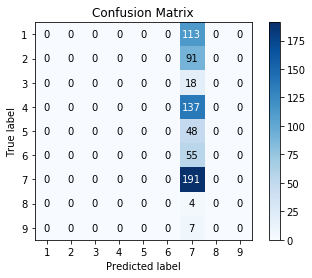

In [161]:
probas = model.predict(X_test)
pred_indices = np.argmax(probas, axis=1)
classes = np.array(range(1, 10))
preds = classes[pred_indices]
print('Log loss: {}'.format(log_loss(classes[np.argmax(Y_test, axis=1)], probas)))
print('Accuracy: {}'.format(accuracy_score(classes[np.argmax(Y_test, axis=1)], preds)))
skplt.plot_confusion_matrix(classes[np.argmax(Y_test, axis=1)], preds)

## 3. Word2Vec embeddings +LSTM

In [59]:
# Load Word2Vec model
embeddings_index = dict()
for word in w2vec.wv.vocab:
    embeddings_index[word] = w2vec.wv[word]
print('Loaded %s vectors' % len(embeddings_index))

Loaded 103335 vectors


In [165]:
# Create a weight matrix
embedding_matrix = np.zeros((vocabulary_size, embed_matrix_dim))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [174]:
vocabulary_size = len(tokenizer.word_index)+1
embed_matrix_dim =100

In [168]:
# Create a LSTM model with pretrained word2vec model
model=EL_model(vocabulary_size,X, embedding_matrix, embed_matrix_dim)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 2000, 100)         18124300  
_________________________________________________________________
lstm_18 (LSTM)               (None, 196)               232848    
_________________________________________________________________
dense_18 (Dense)             (None, 9)                 1773      
Total params: 18,358,921
Trainable params: 234,621
Non-trainable params: 18,124,300
_________________________________________________________________


In [170]:
## Fit train data
model.fit(X_train, Y_train, validation_split=0.2, epochs = 1)


Train on 2121 samples, validate on 531 samples
Epoch 1/1
2121/2121 [==============================] - 265s 125ms/step - loss: 1.8860 - acc: 0.2881 - val_loss: 1.8700 - val_acc: 0.2486
